# Determination of Optimal Initial Threshold

## I. INTRODUCTION
            
Using lesion probability maps created from LST’s Lesion Growth Algorithm (LGA) helps to automate the process of mapping out the lesions visible in our MS subjects’ MRI Images. Unfortunately these lesion probability maps require time-consuming manual edits to correct the False Positives and False Negative. To minimize this issue we created a script to run LST multiple times while iterating through all possible parameters, bin threshold and initial threshold, and created a new metric to evaluate which parameters create the most accurate lesion probability map for any given FLAIR-T1 image pair.

## II. METHODS
 
### A. 
Our first step in this experiment required writing a script to run LST’s provided tool for determining the optimum threshold on a given lesion probability map, while iterating through its one parameter, binary threshold while keeping initial threshold the same. (0.3) The scripts are displayed below:

In [ ]:
from nipype.interfaces.spm.base import SPMCommand, SPMCommandInputSpec
from nipype.interfaces.base import (BaseInterface, TraitedSpec, traits, File,
                                    OutputMultiPath, BaseInterfaceInputSpec,
                                    isdefined, InputMultiPath)
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces.utility import IdentityInterface
import os
#from utils import doit_workflow


class DoitInputSpec(SPMCommandInputSpec):
    data_ref = traits.List(File(exists=True), field="doit.data_ref")
    bin_thresh = traits.Any(0.5, field="doit.bin_thresh", usedefault=True) #default is 0.5


class DoitOutputSpec(TraitedSpec):
    csv_file = OutputMultiPath(File(exists=True))


class Doit(SPMCommand):
    input_spec = DoitInputSpec
    output_spec = DoitOutputSpec
    _jobtype = 'tools'
    _jobname = 'LST'

    def _make_matlab_command(self, contents, postscript=None):
        len_ref = len(self.inputs.data_ref)

        contents = """
        %% Generated by nipype.interfaces.spm
        if isempty(which('spm')),
             throw(MException('SPMCheck:NotFound', 'SPM not in matlab path'));
        end
        [name, version] = spm('ver');
        fprintf('SPM version: %s Release: %s',name, version);
        fprintf('SPM path: %s', which('spm'));
        spm('Defaults','fMRI');

        if strcmp(name, 'SPM8') || strcmp(name(1:5), 'SPM12'),
           spm_jobman('initcfg');
           spm_get_defaults('cmdline', 1);
        end
        """

        contents += """
        jobs{1}.spm.tools.LST.doit.bin_thresh = %f;
        """ % self.inputs.bin_thresh

        for i, ref in enumerate(self.inputs.data_ref):
            contents += """
            jobs{1}.spm.tools.LST.doit.data_ref{%d, 1} = '%s';
        """ % (i+1,
               ref)

        contents += """
                    spm_jobman('run', jobs);
                    """
        return contents

    def _format_arg(self, opt, spec, val):
        """Convert input to appropriate format for spm
        """
        # import numpy as np
        # from nipype.utils.filemanip import copyfiles

        # if opt in ['t1_files', 'flair_files']:
        #    val2 = copyfiles(val, os.path.abspath("."))
        #    return np.array(val2, dtype=object)
        print("_format_arg opt is: ", opt)
        print("_format_arg opt is: ", spec)
        print("_format_arg opt is: ", val)

        # TODO change the format of data_ref

        return super(Doit, self)._format_arg(opt, spec, val)


    def _list_outputs(self):
        #from nipype.utils.filemanip import fname_presuffix
        from glob import glob
        from os.path import join
        outputs = self._outputs().get()
        print("Listing outputs!")
        print(os.path.abspath('.'))

        outputs["csv_file"] = glob(join(os.path.abspath('.'), "LST_doit_*.csv"))
        print(outputs)
        return outputs

__Three python files were written in the same directory. The script above wraps SPM command into python to run LGA. The file name is doit_spm.py__

In [ ]:
__author__ = 'sf713420'

import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces.utility import IdentityInterface
import os
import sys
print(__file__)
print(sys.path)
sys.path.append(os.path.dirname(__file__))
import numpy as np
from doit_spm import Doit

def flatten(l):
    return [item for sublist in l for item in sublist]

def doit_workflow(data_ref, bin_thresh, base_dir = None, sink_dir = None):
    # data_ref should be a list of pathname
    # base_dir is the working directory
    # sink_dir is where the data is sinking
    if base_dir is None:
        base_dir = os.getcwd()
        print("base_dir is: ", base_dir)
    if sink_dir is None:
        sink_dir = base_dir
        print("sink_dir is: ", sink_dir)

    count = 0


    # inputs
    inputspec = pe.Node(IdentityInterface(fields = ['data_ref', 'thresh']), name = 'inputspec')
    inputspec.inputs.mandatory_inputs = True
    inputspec.inputs.data_ref = data_ref
    inputspec.inputs.thresh = bin_thresh


    # doit_node
    doit_node = pe.Node(name = 'doit_node',
                           interface = Doit(),
                           #iterfield = ['data_ref']
                           )
    doit_node.iterables = ("bin_thresh", bin_thresh)
    # TODO
    print(doit_node.iterables)
    print(doit_node.inputs.bin_thresh)

    #datasink
    data_sink = pe.Node(nio.DataSink(), name = 'sinker')
    data_sink.inputs.base_directory = sink_dir
    data_sink.inputs.container = '.'

    # Pipeline assembly
    pipeline = pe.Workflow(name = 'pipeline_doit')
    pipeline.base_dir = base_dir

    pipeline.connect(inputspec, 'data_ref', doit_node, 'data_ref')
    pipeline.connect(inputspec, 'thresh', doit_node, 'bin_thresh')
    pipeline.connect(doit_node, 'csv_file', data_sink, '@LST_doit')

    pipeline.write_graph(graph2use = 'orig')
    pipeline.config['Execution'] = {'keep_inputs': True, 'remove_unnecessary_outputs': False}

    return pipeline

__A nipype workflow was made to iterate through binary threshold with increment 0.05. The file name is utils.py__

In [ ]:
__author__ = 'sf713420'

import os
from nipype.interfaces.base import isdefined
from utils import doit_workflow, flatten
import sys
from glob import glob
import numpy as np
import csv

if __name__ == '__main__':
    print("Reading file from the path: ", sys.argv[1], "\n")
    data_ref = glob(sys.argv[1])

    FLAIR_T1_name = data_ref[0].split('/')[5]
    output_dir = '/data/henry1/tristan/LST/opt_thresh_results'
    sk_dir = os.path.join(output_dir,
                          FLAIR_T1_name
                          )

    dwf = doit_workflow(data_ref, thresh_array, sink_dir=sk_dir)
    dwf.run()
    
    """
    with open(os.path.join(sk_dir, '_bin_thresh_' + thresh_array[i]), newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

    csvfile.close()
    """

__This script takes the first positional argument as filename for running the LGA DC calculation workflow. The script is name as doit_arg.py__

The csv files are generated for each binary threshold. All of them includes 102 mses which are FLAIR-MPRAGE image pairs. The average Dice Coefficient (DC), Sensitivity (SE) and Specificity (SP) among these mses were calculated.

### B. 
The next step a script that would run LST’s LGA on a given FLAIR-T1 image pair while iterating through its one parameter, initial threshold (also know as kappa) was run. The multiple lesion probability maps created would then be analyzed using LST’s provided tool for determining the optimum threshold to evaluate which initial threshold will create a map that requires the least amount of manual edits. The LGA iteration for initial threshold (kappa) increment of 0.05 was run in PBR. 5 test mses (mse3727, mse4413, mse4482, mse4739, mse4754) were run and outputs were calculated using previous code with binary threshold set to 0.3. The code is shown below:

In [ ]:
__author__ = 'sf713420'
from nipype.interfaces.base import (BaseInterface, TraitedSpec, traits, File,
                                    OutputMultiPath, BaseInterfaceInputSpec,
                                    isdefined, InputMultiPath)

from ...config import config
from glob import glob
import os
from ...base import register_workflow, PBRBaseInputSpec, PBRBaseInterface
from nipype.interfaces.spm.base import SPMCommand, SPMCommandInputSpec

class LGAInputSpec(SPMCommandInputSpec):
    t1_files = traits.List(File(exists=True), field="lga.data_T1")
    flair_files = traits.List(File(exists=True), field="lga.data_F2")
    kappa = traits.Float(0.3, field="lga.opts_lga.initial", usedefault=True)
    maxiter = traits.Int(50, field="lga.opts_lga.maxiter", usedefault=True)
    phi = traits.Float(1.0, field="lga.opts_lga.mrf", usedefault=True)
    html_report = traits.Bool(0, field="lga.html_report", usedefault=True)

class LGAOutputSpec(TraitedSpec):
    lesion_probability_map = OutputMultiPath(File(exists=True))
    mat_file = OutputMultiPath(File(exists=True))
    bias_corrected_flair = OutputMultiPath(File(exists=True))


class LGA(SPMCommand):
    input_spec = LGAInputSpec
    output_spec = LGAOutputSpec
    _jobtype = 'tools'
    _jobname = 'LST'

    def _format_arg(self, opt, spec, val):
        """Convert input to appropriate format for spm
        """
        import numpy as np
        from nipype.utils.filemanip import copyfiles

        if opt in ['t1_files', 'flair_files']:
            val2 = copyfiles(val, os.path.abspath("."))
            return np.array(val2, dtype=object)

        return super(LGA, self)._format_arg(opt, spec, val)

    def _list_outputs(self):
        from nipype.utils.filemanip import fname_presuffix
        outputs = self._outputs().get()
        kappa = round(self.inputs.kappa, 2)

        if str(kappa) == '1.0':
            kappa = 1

        outputs["lesion_probability_map"] = [fname_presuffix(f,
                                                prefix="ples_lga_{}_rm".format(kappa),
                                                newpath=os.path.abspath(".")) for f in self.inputs.flair_files]
        outputs["bias_corrected_flair"] = [fname_presuffix(f,
                                                prefix="rm",
                                                newpath=os.path.abspath(".")) for f in self.inputs.flair_files]
        outputs["mat_file"] = [fname_presuffix(f,
                                                prefix="LST_lga_rm",
                                                newpath=os.path.abspath("."),
                                                use_ext=False)+".mat"  for f in self.inputs.flair_files]
        return outputs


def mapper(Nt1, t1):
    return [t1[Nt1]]

def mapper2(Nt2, t2):
    return [t2[Nt2]]


class LGAIterInputSpec(PBRBaseInputSpec):
    t1_files = InputMultiPath(File(exists=True))
    flair_files = InputMultiPath(File(exists=True))

class LGAIterOutputSpec(TraitedSpec):
    lesion_probability_mask_lga = OutputMultiPath(File(exists=True))
    lesion_binary_ref = OutputMultiPath(File(exists=True))
    lga_mat = OutputMultiPath(File(exists=True))
    lga_txt = OutputMultiPath(File(exists=True))
    lga_index = OutputMultiPath(File(exists=True))
    lga_metrics = OutputMultiPath(traits.Dict())

class LGAIter(PBRBaseInterface):
    """
    """
    input_spec = LGAIterInputSpec
    output_spec = LGAIterOutputSpec
    flag = "lga" #this is for pbr mse# -w interfacename
    connections = [("align", "t1_files", "t1_files"),
                   ("align", "flair_files", "flair_files")]

    def _run_interface_pbr(self, runtime):
        from nipype.pipeline.engine import Node, Workflow, MapNode
        from nipype.interfaces.io import DataSink
        import nipype.algorithms.misc as misc
        from nipype.interfaces.utility import IdentityInterface, Function
        import numpy as np

        wf = Workflow(name="lga_%s"%self.inputs.mseID)
        wf.base_dir = os.path.join(config["working_directory"])

        #get_ratio_workflow(config)
        inputspec = Node(IdentityInterface(["t1s", "flairs"]), name="inputspec")
        #wf.get_node("inputspec")
        #inputspec.inputs.examID = self.inputs.mseID

        map_func = Node(Function(input_names=["Nt1", "t1"],
                                 output_names=["t1"],
                                 function=mapper),
                        name="stupid_mapper")

        map_func2 = Node(Function(input_names=["Nt2", "t2"],
                                 output_names=["t2"],
                                 function=mapper2),
                        name="stupid_mapper2")

        map_func.inputs.t1 = self.inputs.t1_files
        map_func2.inputs.t2 = self.inputs.flair_files

        map_func.iterables = [('Nt1', range(len(self.inputs.t1_files)))]
        map_func2.iterables = [('Nt2', range(len(self.inputs.flair_files)))]

        wf.connect(map_func, "t1", inputspec, "t1s")
        wf.connect(map_func2, "t2", inputspec, "flairs")

        gunzip_t1 = MapNode(interface=misc.Gunzip(), name='gunzip_t1', iterfield=["in_file"])
        gunzip_flair = MapNode(interface=misc.Gunzip(), name='gunzip_flair', iterfield=["in_file"])
        wf.connect(inputspec, "t1s", gunzip_t1, "in_file")
        wf.connect(inputspec, "flairs", gunzip_flair, "in_file")

        lga = Node(LGA(), name="lga")
        init_thresh = np.linspace(0.05, 1.00, num=20)
        lga.iterables = ("kappa", init_thresh)
        # or lga.inputs.kappa = init_thresh (?)
        wf.connect(gunzip_t1, "out_file", lga, "t1_files")
        wf.connect(gunzip_flair, "out_file", lga, "flair_files")

        sinker = Node(DataSink(), name="sinker")
        sinker.inputs.base_directory = config["output_directory"]
        sinker.inputs.container = self.inputs.mseID

        import nipype.interfaces.fsl as fsl
        cluster_lga = MapNode(fsl.Cluster(threshold=0.0001,
                                          out_index_file = True,
                                          #out_localmax_txt_file=True,
                                          use_mm=True),
                              name="cluster_lga",
                              iterfield=["in_file"])
        wf.connect(lga, "lesion_probability_map", cluster_lga, "in_file")
        wf.connect(cluster_lga, "index_file", sinker, "lst.lga.cluster")

        from nipype.interfaces.freesurfer import SegStats
        segstats_lga = MapNode(SegStats(), name="segstats_lga", iterfield=["segmentation_file"])
        wf.connect(cluster_lga, "index_file", segstats_lga, "segmentation_file")

        wf.connect(segstats_lga, "summary_file", sinker, "lst.lga.@summaryfile")

        def getsubs(t1,t2):
            # Make substitutions
            subs = [("_Nt1_%d/_Nt2_%d/_segstats_lga0/summary.stats"%(i,j),
                     "{}/{}_summary.stats".format(t1[i].split("/")[-1].split(".nii.gz")[0],
                                     t2[j].split("/")[-1].split(".nii.gz")[0])) \
                     for i in range(len(t1)) for j in range(len(t2))]
            subs += [("_Nt1_%d/_Nt2_%d"%(i,j),t1[i].split("/")[-1].split(".nii.gz")[0]) for i in range(len(t1)) for j in range(len(t2))]
            subs += [("_Nt2_%d"%i, "") for i in range(10)]
            subs += [("_cluster_lga0", "")]
            return subs

        subs = Node(Function(input_names=["t1", "t2"],
                             output_names=["subs"],
                             function=getsubs),
                    name="subs")
        #sinker.inputs.substitutions = getsubs()
        wf.connect(map_func, "t1", subs, "t1")
        wf.connect(map_func2, "t2", subs, "t2")
        wf.connect(subs, "subs", sinker, "substitutions")
        wf.connect(lga, "lesion_probability_map", sinker, "lst.lga.@map")
        wf.connect(lga, "mat_file", sinker, "lst.lga.@mat")

        wf.config = {"execution": {"crashdump_dir": os.path.join(config["crash_directory"],
                                                                 self.inputs.mseID,
                                                                 self.flag)}}
        wf.run(plugin=self.inputs.plugin,
               plugin_args=self.inputs.plugin_args)

        return runtime


    def _get_output_folder(self):
        # output folder for status.json
        return "lst/lga"

    def get_metrics(self, f):
        import numpy as np
        if os.path.exists(f):
            foo = np.genfromtxt(f)
            print("foo.shape is", foo.shape)
            if len(foo.shape)==2:
                data = foo[:,3][1:]
                output = {"number_of_lesions": data.shape[0],
                          "total_lesion_volume": np.sum(data),
                          "max_lesion_size": np.max(data)}
                return output
            else:
                return {"number_of_lesions": 0}
        else:
            raise FileNotFoundError


    def _list_outputs(self):
        # managing outputs for later calculate Dice Coefficient
        import shutil  # copy2 also copy file metadata like file's creation and modification times
        import numpy as np
        from glob import glob

        bin_map_dir = "/data/henry1/tristan/LST/FLAIR-MPRAGE" # TODO make a dictionary
        bin_map = "*-{0}*_bin_lesion_map.nii".format(self.inputs.mseID)
        src = ''.join(glob(os.path.join(bin_map_dir, self.inputs.mseID, bin_map)))
        dstnames = glob(os.path.join(config["output_directory"], self.inputs.mseID,
                                     "lst", "lga", "*", "_kappa_*"))
        for dst in dstnames:
            shutil.copy(src, dst)

        outputs = self._outputs().get()

        outputs["lesion_probability_mask_lga"] = sorted(glob(os.path.join(config["output_directory"],
                                                   self.inputs.mseID, "lst","lga","*",
                                                   "_kappa_*", "ples_lga*.nii")))
        outputs["lesion_binary_ref"] = sorted(glob(os.path.join(config["output_directory"], self.inputs.mseID,
                                                                "lst", "lga", "*", "_kappa_*", bin_map)))
        outputs["lga_mat"] = sorted(glob(os.path.join(config["output_directory"],
                                                   self.inputs.mseID, "lst","lga","*",
                                                   "_kappa_*", "*.mat")))
        outputs["lga_txt"] = sorted(glob(os.path.join(config["output_directory"],
                                                   self.inputs.mseID, "lst","lga","*",
                                                   "_kappa_*", "_segstats_lga0", "*.stats")))
        outputs["lga_index"] = sorted(glob(os.path.join(config["output_directory"],
                                                   self.inputs.mseID, "lst","lga","*",
                                                   "_kappa_*", "cluster", "*_index.nii.gz")))
        outputs["lga_metrics"] = [self.get_metrics(f) for f in outputs["lga_txt"]]

        return outputs

register_workflow(LGAIter)

__PBR interface for running LGA with kappa of increment 0.05__

In [ ]:
__author__ = 'sf713420'

import os
from nipype.interfaces.base import isdefined
from utils import doit_workflow, flatten
import sys
from glob import glob
import numpy as np
import csv

if __name__ == '__main__':
    iter = sys.argv[1]
    mse_test = ['mse3727', 'mse4413', 'mse4482', 'mse4739', 'mse4754']
    data_ref = [glob('/data/henry7/PBR/subjects/{0}/lst/lga/ms*/*/*_bin_lesion_map.nii'.format(mse)) for mse in mse_test]
    data_ref = flatten(data_ref)
    print(data_ref,'\n', len(data_ref))

    output_dir = '/data/henry1/tristan/LST/opt_thresh_results/test_subjects'
    sk_dir = os.path.join(output_dir)
    
    if iter == '-iter':
        thresh_array = np.linspace(0.05, 1.00, num=20)
    elif isdefined(iter):
        raise ValueError("The option for iterate binary threshold is -iter")

    dwf = doit_workflow(data_ref, thresh_array, sink_dir=sk_dir)
    dwf.run()

__This script takes the first positional argument as option for either iterating or not binary threshold for running the LGA DC calculation workflow. __

### C. New Metric 

The new metric is based on combination of voxel-based DC (vDC) and lesion-based DC (lDC). vDC is already calculated based on the formula:
<center>lDC = 2TP / (2TP + FP + FN)</center>
where TP, FP and FN are voxel-wise True Positive, False Positive and False Negative respectively.
lDC is obtained by doing: 
1. Get centroids reference lesion and map it to LGA lesion. Lesion-based False Negative and True Positive (TP1) are computed.
2. Get centroids of LGA lesion and map it back to reference lesion. Lesion-based False Positive (FP) and True Positive (TP2) are computed.
TP1 and TP2 are not necessary the same due to the algorithm to find centroid depending on the shape of lesions. If the shape and size of LGA lesions and reference lesions are much different, the centroid of one lesion may not overlap with the other lesion. Taking this condition into account, the formula for calculating lDC is modified:
<center>lDC = (TP1 + TP2) / (TP1 + TP2 + FP + FN)</center>
The new metric weighting 0.5 for both vDC and lDC:
<center>New Metric = 0.5 * vDC + 0.5 * lDC</center>

All ralted code are on the [Github Repository](https://github.com/zxh2135645/LST.git) 

## III. Results

### A. Table of Binary Threshold Results

In [5]:
# from IPython.display import display, HTML
import pandas as pd
df1 = pd.read_csv("/data/henry1/tristan/LST/opt_thresh_results/FLAIR-MPRAGE/averages.csv")
print(df1)

    Threshold  Dice_Coefficient        SE        SP
0        0.05          0.475833  0.358878  0.999789
1        0.10          0.468314  0.349578  0.999817
2        0.15          0.463385  0.343767  0.999832
3        0.20          0.459555  0.339401  0.999842
4        0.25          0.456596  0.336025  0.999849
5        0.30          0.454107  0.333195  0.999855
6        0.35          0.451778  0.330667  0.999859
7        0.40          0.449665  0.328433  0.999862
8        0.45          0.447638  0.326332  0.999865
9        0.50          0.446124  0.324714  0.999868
10       0.55          0.444625  0.323119  0.999870
11       0.60          0.443311  0.321718  0.999872
12       0.65          0.441971  0.320329  0.999874
13       0.70          0.440737  0.319028  0.999876
14       0.75          0.439719  0.317954  0.999878
15       0.80          0.438657  0.316840  0.999879
16       0.85          0.437700  0.315826  0.999880
17       0.90          0.436781  0.314869  0.999882
18       0.9

Table 1. Averaged Dice Coefficient, SE and SP for all FLAIR-MPRAGE mses with 0.05 increment of binary threshold.

As is shown in the table, DC decreases with binary threshold increasing. This indicate that the binary threshold has monotonous effect in determining DC. In this case, we will use binary threshold = 0.3 for the later determination of optimal initial threshold.

### B. Table of Initial Threshold Results

In [11]:
import pandas as pd
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
df2 = pd.read_csv("/data/henry1/tristan/LST/opt_thresh_results/test_subjects/_bin_thresh_0.3/For_Jupyter_Display.csv")
print_full(df2)

                         FLAIR  kappa        DC        SE       SP
0   rmms1624-mse3727-077-FLAIR   0.05  0.551630  0.481400  0.99923
1   rmms1624-mse3727-077-FLAIR   0.10  0.533100  0.379960  0.99987
2   rmms1624-mse3727-077-FLAIR   0.15  0.462580  0.304510  0.99996
3   rmms1624-mse3727-077-FLAIR   0.20  0.395480  0.247350  0.99999
4   rmms1624-mse3727-077-FLAIR   0.25  0.338160  0.203700  1.00000
5   rmms1624-mse3727-077-FLAIR   0.30  0.312060  0.184990  1.00000
6   rmms1624-mse3727-077-FLAIR   0.35  0.269330  0.155680  1.00000
7   rmms1624-mse3727-077-FLAIR   0.40  0.248320  0.141760  1.00000
8   rmms1624-mse3727-077-FLAIR   0.45  0.233200  0.131990  1.00000
9   rmms1624-mse3727-077-FLAIR   0.50  0.206520  0.115150  1.00000
10  rmms1624-mse3727-077-FLAIR   0.55  0.196780  0.109120  1.00000
11  rmms1624-mse3727-077-FLAIR   0.60  0.192030  0.106210  1.00000
12  rmms1624-mse3727-077-FLAIR   0.65  0.178690  0.098109  1.00000
13  rmms1624-mse3727-077-FLAIR   0.70  0.164090  0.089379  1.0

Table 2. Initial threshold (kappa) with increment of 0.05 for 5 mse subjects. The DC, SE and SP are displayed.

### C. New Metric Results
#### I. New Metric Table

In [23]:
import pandas as pd
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
df3 = pd.read_csv('/data/henry1/tristan/LST/opt_thresh_results/test_subjects/_bin_thresh_0.3/final_metric.csv', 
                 index_col=None)
print_full(df3.ix[:, 1:])

        mse  kappa  TP_to_ref  TP_to_lga  FP   FN  LesionDC   VoxelDC  \
0   mse3727   0.05         32         25  38   38  0.428571  0.551630   
1   mse3727   0.10         22         18  13   45  0.408163  0.533100   
2   mse3727   0.15         15         13   3   50  0.345679  0.462580   
3   mse3727   0.20         16         11   1   52  0.337500  0.395480   
4   mse3727   0.25         16          8   0   55  0.303797  0.338160   
5   mse3727   0.30         13          6   0   57  0.250000  0.312060   
6   mse3727   0.35         13          6   0   57  0.250000  0.269330   
7   mse3727   0.40          9          4   0   59  0.180556  0.248320   
8   mse3727   0.45          6          4   0   59  0.144928  0.233200   
9   mse3727   0.50          5          3   0   60  0.117647  0.206520   
10  mse3727   0.55          4          2   0   61  0.089552  0.196780   
11  mse3727   0.60          4          2   0   61  0.089552  0.192030   
12  mse3727   0.65          3          2   0   61  

#### II. New Metric Plot

[ 0.47398178  0.52469356  0.48287402  0.4262577   0.38684999  0.3550544
  0.31064015  0.27586232  0.25234679  0.23217605  0.20933155  0.19576094
  0.17096955  0.14667001  0.12614577  0.10169389  0.08059833  0.06974047
  0.06133832  0.0521765 ]


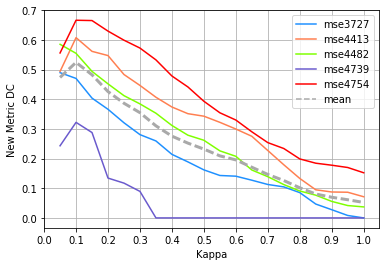

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

df4 = pd.read_csv('/data/henry1/tristan/LST/opt_thresh_results/test_subjects/_bin_thresh_0.3/final_metric.csv', 
                 index_col=None)
mse3727 = df4['NewMetric_DC'].ix[:19].values
mse4413 = df4['NewMetric_DC'].ix[20:39].values
mse4482 = df4['NewMetric_DC'].ix[40:59].values
mse4739 = df4['NewMetric_DC'].ix[60:79].values
mse4754 = df4['NewMetric_DC'].ix[80:99].values
mean = (mse3727 + mse4413 + mse4482 + mse4739 + mse4754) / 5
print(mean)

plt.figure(1)
ax = plt.subplot()
kappa = np.arange(0.05, 1.05, 0.05)
# print(x)
plt.plot(kappa, mse3727, 'dodgerblue')
plt.plot(kappa, mse4413, 'coral')
plt.plot(kappa, mse4482, 'chartreuse')
plt.plot(kappa, mse4739, 'slateblue')
plt.plot(kappa, mse4754, 'r')
plt.plot(kappa, mean, 'darkgrey', linewidth=3, linestyle='--')

plt.ylabel('New Metric DC')
plt.xlabel('Kappa')
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))

blue_line = mlines.Line2D([], [], color='dodgerblue', label='mse3727')
orange_line = mlines.Line2D([], [], color='coral', label='mse4413')
green_line = mlines.Line2D([], [], color='chartreuse', label='mse4482')
purple_line = mlines.Line2D([], [], color='slateblue', label='mse4739')
red_line = mlines.Line2D([], [], color='r', label='mse4754')
grey_line = mlines.Line2D([], [], color='darkgrey', linestyle='--', label='mean')
plt.legend(handles=[blue_line, orange_line, green_line, purple_line, red_line, grey_line])


plt.show()

Figure 1. Plot of new metric DC for 5 ms exams with kappa incrementing of 0.05 from 0.05 to 1. Mean of 5 mses are plotted with grey dashed line.

## IV. Discussion

### A. 
The threshold in Table 1 is binary threshold for the computation of LGA binary lesion maps, The threshold can be set between 0 to 1, where the thresholding is more liberal when it's set close to 0 and more conservative when it's set close 1. We concluded from Table 1 the binary threshold has a monotonous effect in determining DC, it will not affect the accuracy of determination of kappa across different subjects as long as binary threshold is kept the same. In this case, binary threshold is set to 0.3 for future determination of optimal initial threshold.

### B. 
The table in our results displays the outputs of LST’s provided tool for determining the optimal threshold for 5 test subjects iterated over 20 values of kappa (0.05 - 1.0).  Our iteration through various kappa values shows us that the Dice Coefficient is generally inversely proportional to the initial threshold. This implies that a lower kappa value will produce a more accurate lesion map. However, upon inspection of the lesion maps in comparison to manually created and edited lesion maps of the same test subject it appeared that this was not necessarily the case. It is true that we see the least False Negatives in the lesion maps created with the lowest kappa values. However these maps also create False Positives due to their extremely low threshold, and in some cases did not appear to have the most accurate lesion maps. This disparity between the lesion map with the highest Dice Coefficient and the most accurate lesion map calls for a new metric to be used in measuring LGA lesion maps’ accuracy. 

### C.

As is shown in figure 1, the new DC is highest when kappa is 0.05 or 0.1 for five different mses. In addition, the mean of five subjects denotes new DC is highest when kappa is 0.1. Lower kappa will raise number of FP but lower number of FN. Considering when doing quality control for FN and FP, it is always less painful for people to erase FP lesions than draw new lesions on the FN location. Both evidence suggests that we lower default kappa value (0.3) to 0.05 or 0.1, with 0.1 preferred.

(Plotting of brain image to be continued)